# Synthetic dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import shap

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['legend.fontsize'] = 16

def plot_contribution(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None, cmap=plt.get_cmap('viridis', 36)):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i),fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
        else:
            c = ax.imshow(b[i].reshape(size, size), cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='x', colors=(0,0,0,0))
            ax.tick_params(axis='y', colors=(0,0,0,0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.pdf', bbox_inches='tight')

## Data generation

In [3]:
size = 50

b0 = np.ones((size, size))
b1 = np.ones((size, size))
b2 = np.ones((size, size))
b3 = np.ones((size, size))
b4 = np.ones((size, size))
# noise = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b0[i, j] = 6 * np.exp(-((i - 40)**2 + (j - 10)**2) / (2 * 12**2)) + 6 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))
        b1[i, j] = i / 49 * 6
        b2[i, j] = (i + j) / 49 * 3
        b3[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 12**2))
        # b3[i, j] = (j / 49) * 6
        # b3[i, j] = 6 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 6 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))
        # noise[i, j] = 4 * np.exp(-((i - 40)**2 + (j - 10)**2) / (2 * 12**2)) + 4 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))

# b3 = np.flip(b2, axis=1).T
# b3 = np.ones(size*size).reshape(-1)*2


In [4]:
b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = b3.reshape(-1)
# b4 = b4.reshape(-1)
# noise = noise.reshape(-1)

In [5]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size * size)
X2 = np.random.uniform(-2, 2, size * size)
X3 = np.random.uniform(-2, 2, size * size)
X4 = np.random.uniform(-2, 2, size * size)
X5 = np.random.uniform(-2, 2, size * size)

X = np.vstack([X1, X2, X3, X4, X5]).T
u = np.array([np.linspace(0,size - 1,num=size)] * size).reshape(-1)
v = np.array([np.linspace(0,size - 1,num=size)] * size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1]
n = X.shape[0]

In [6]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1), columns=['X1', 'X2', 'X3', 'X4', 'X5', 'x_coord', 'y_coord'])

In [7]:
X_coords

X1        X2        X3        X4        X5  x_coord  y_coord
0     0.104114  0.964917  1.011381  1.192011  1.623438      0.0      0.0
1     0.741269 -0.440030 -0.936705  1.024414  1.663881      1.0      0.0
2     1.342697 -0.875739 -1.148677 -1.992029 -0.209243      2.0      0.0
3     0.615061  1.082512 -1.266801 -0.424231  0.540090      3.0      0.0
4    -1.851912  0.026923 -0.659943  1.062233 -0.125796      4.0      0.0
...        ...       ...       ...       ...       ...      ...      ...
2495 -1.798074 -0.779403  0.012337 -1.363451 -1.925222     45.0     49.0
2496  0.239688 -0.666447  0.497581  0.348732  0.100871     46.0     49.0
2497 -1.719665 -1.038000 -0.700350  1.508266  0.610802     47.0     49.0
2498 -0.650496 -1.045958  0.776005  1.999300  1.650016     48.0     49.0
2499  0.801800 -0.750421  0.581807  0.487717  1.276653     49.0     49.0

[2500 rows x 7 columns]

In [8]:
# f0 = b0
f1 = b1 * X_coords.values[:, 0]
f2 = b2 * X_coords.values[:, 1]
f3 = b3 * X_coords.values[:, 2]
f4 = X_coords.values[:, 3] * 2
f5 = X_coords.values[:, 4] ** 2

In [9]:
y = pd.DataFrame(f1 + f2 + f3 + f4 + f5 + b0, columns=['y'])

In [10]:
b = [b0, b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5]]
# b = [b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5]]

In [11]:
sub_titles = [r'$f_0(u,v)$', r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$']
# sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$']

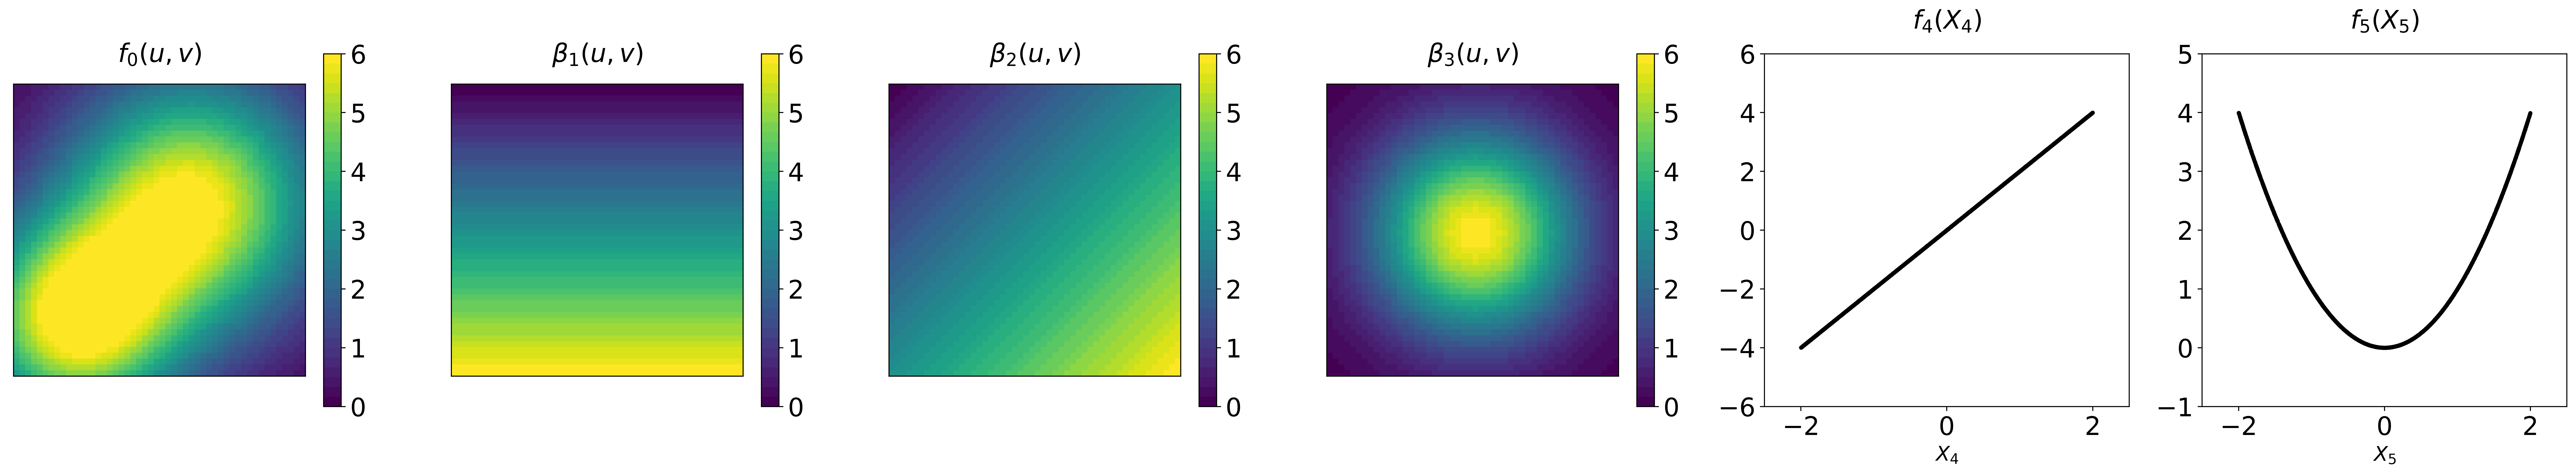

In [12]:
plot_contribution(b=b, k=6, sub_titles=sub_titles, vmin=0, vmax=6, title='TrueModel', non_spatial=[4, 5])

In [13]:
class Model:
    def __init__(self, f):
        self.predict = f

In [14]:
def predict_with_uncertainty(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        f0 = 6 * np.exp(-((i - 40)**2 + (j - 10)**2) / (2 * 12**2)) + 6 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 12**2)) * X_coords[i, 2]
        f4 = X_coords[i, 3] * 2
        f5 = X_coords[i, 4] ** 2
        # noise = 4 * np.exp(-((i - 40)**2 + (j - 10)**2) / (2 * 12**2)) + 4 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))

        y = f0 + f1 + f2 + f3 + f4 + f5
        # y = f1 + f2 + f3 + f4 + f5 + noise
        y_pred.append(y)
    return np.array(y_pred)

In [75]:
def predict_without_uncertainty(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        # f0 = 6 * np.exp(-((i - 40)**2 + (j - 10)**2) / (2 * 12**2)) + 6 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 12**2)) * X_coords[i, 2]
        f4 = X_coords[i, 3] * 2
        f5 = X_coords[i, 4] ** 2

        y = f1 + f2 + f3 + f4 + f5
        # y = f1 + f2 + f3 + f4 + f5
        y_pred.append(y)
    return np.array(y_pred)

In [76]:
true_model_with_uncertainty = Model(predict_with_uncertainty)
true_model_without_uncertainty = Model(predict_without_uncertainty)

In [17]:
loc = X_coords[['x_coord', 'y_coord']]

In [18]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [19]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5, random_state=42)

In [20]:
X_train, X_calib, loc_train, loc_calib = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [21]:
explainer_with_uncertainty = GeoConformalizedExplainer(true_model_with_uncertainty, X_train, X_calib, loc_calib.values, loc.values, 0.1, 15)

In [22]:
results = explainer_with_uncertainty.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

Training SHAP


ExactExplainer explainer: 2001it [03:46,  8.54it/s]                          


Calibrating SHAP


ExactExplainer explainer: 501it [00:58,  7.17it/s]                         


Testing SHAP


ExactExplainer explainer: 2501it [04:55,  8.16it/s]                          


Explaining Variables


In [23]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     0.9812  0.985190  0.461032  14.351503      13.638022
X2                     1.0000  0.991446  0.342886  13.744439      13.249236
X3                     0.9824  0.989484  0.250331   5.959126       6.274525
X4                     1.0000  0.999539  0.050387   5.507229       5.471242
X5                     0.7476  0.964459  0.223735   1.408434       1.359133
x_coord                0.9824  0.935639  0.212755   0.703292       0.691452
y_coord                0.9420  0.953790  0.292336   1.849375       1.747275

In [24]:
pred_results = results.result_geo

In [25]:
pred_results

X1_shap   X2_shap   X3_shap   X4_shap   X5_shap  x_coord_shap  \
0     0.268274  1.426137  0.650887  2.457662  1.016148     -1.316788   
1     1.337915 -0.876348 -0.954648  2.122467  1.149098      0.475101   
2     2.347577 -1.625549 -1.152772 -3.910418 -1.575619      0.828853   
3     1.126040  1.720825 -1.280184 -0.774823 -1.327704     -0.557612   
4    -3.015454 -0.094818 -0.764572  2.198105 -1.603577     -0.024356   
...        ...       ...       ...       ...       ...           ...   
2495 -7.694052 -3.547848 -0.159196 -2.653295  2.087047     -0.705703   
2496  1.840178 -3.057885  0.285607  0.771072 -1.609259     -0.804368   
2497 -7.327196 -4.774675 -0.799145  3.090139 -1.246355     -0.690477   
2498 -2.324793 -4.841861  0.502304  4.072208  1.103120     -1.222836   
2499  4.470175 -3.504316  0.320482  1.049042  0.010410     -0.989855   

      y_coord_shap  X1_value  X2_value  X3_value  ...  x_coord_pred  \
0        -1.306137  0.104114  0.964917  1.011381  ...     -1.386184   
1        -0.452509  0.741269 -0.440030 -0.936705  ...      0.681732   
2        -0.987416  1.342697 -0.875739 -1.148677  ...      1.045690   
3        -1.328587  0.615061  1.082512 -1.266801  ...     -0.168133   
4         3.451318 -1.851912  0.026923 -0.659943  ...      0.252874   
...            ...       ...       ...       ...  ...           ...   
2495     -3.521345 -1.798074 -0.779403  0.012337  ...     -0.498346   
2496     -0.970947  0.239688 -0.666447  0.497581  ...     -0.580655   
2497     -3.289980 -1.719665 -1.038000 -0.700350  ...     -0.477446   
2498     -2.483760 -0.650496 -1.045958  0.776005  ...     -1.232815   
2499     -0.280924  0.801800 -0.750421  0.581807  ...     -0.837173   

      y_coord_geo_uncertainty  y_coord_uncertainty  y_coord_upper_bound  \
0                    0.348827             0.459678            -1.037985   
1                    0.348827             0.459678            -0.072996   
2                    0.350498             0.459678            -0.508594   
3                    0.353256             0.459678            -0.794540   
4                    0.353256             0.459678             3.471958   
...                       ...                  ...                  ...   
2495                 0.543313             0.459678            -2.584704   
2496                 0.539918             0.459678            -0.007966   
2497                 0.539918             0.459678            -2.331353   
2498                 0.539918             0.459678            -1.591929   
2499                 0.539918             0.459678             0.632480   

      y_coord_lower_bound  y_coord_coverage_probability  y_coord_pred     x  \
0               -1.735639                         0.942     -1.386812   0.0   
1               -0.770651                         0.942     -0.421824   1.0   
2               -1.209589                         0.942     -0.859092   2.0   
3               -1.501052                         0.942     -1.147796   3.0   
4                2.765446                         0.942      3.118702   4.0   
...                   ...                           ...           ...   ...   
2495            -3.671330                         0.942     -3.128017  45.0   
2496            -1.087802                         0.942     -0.547884  46.0   
2497            -3.411189                         0.942     -2.871271  47.0   
2498            -2.671765                         0.942     -2.131847  48.0   
2499            -0.447355                         0.942      0.092562  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (47.00000 49.00000)  
2498  49.0  POINT (48.00000 49.00000)  

In [26]:
sub_titles = [r'$\phi_{GEO}$', r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\phi_4$', r'$\phi_5$']

In [27]:
pred_b = [pred_results['x_coord_pred'].values + pred_results['y_coord_pred'].values,
          pred_results['X1_pred'].values,
          pred_results['X2_pred'].values,
          pred_results['X3_pred'].values,
          [X_coords.values[:, 3], pred_results['X4_pred'].values, -6, 6],
          [X_coords.values[:, 4], pred_results['X5_pred'].values, -3, 3]]

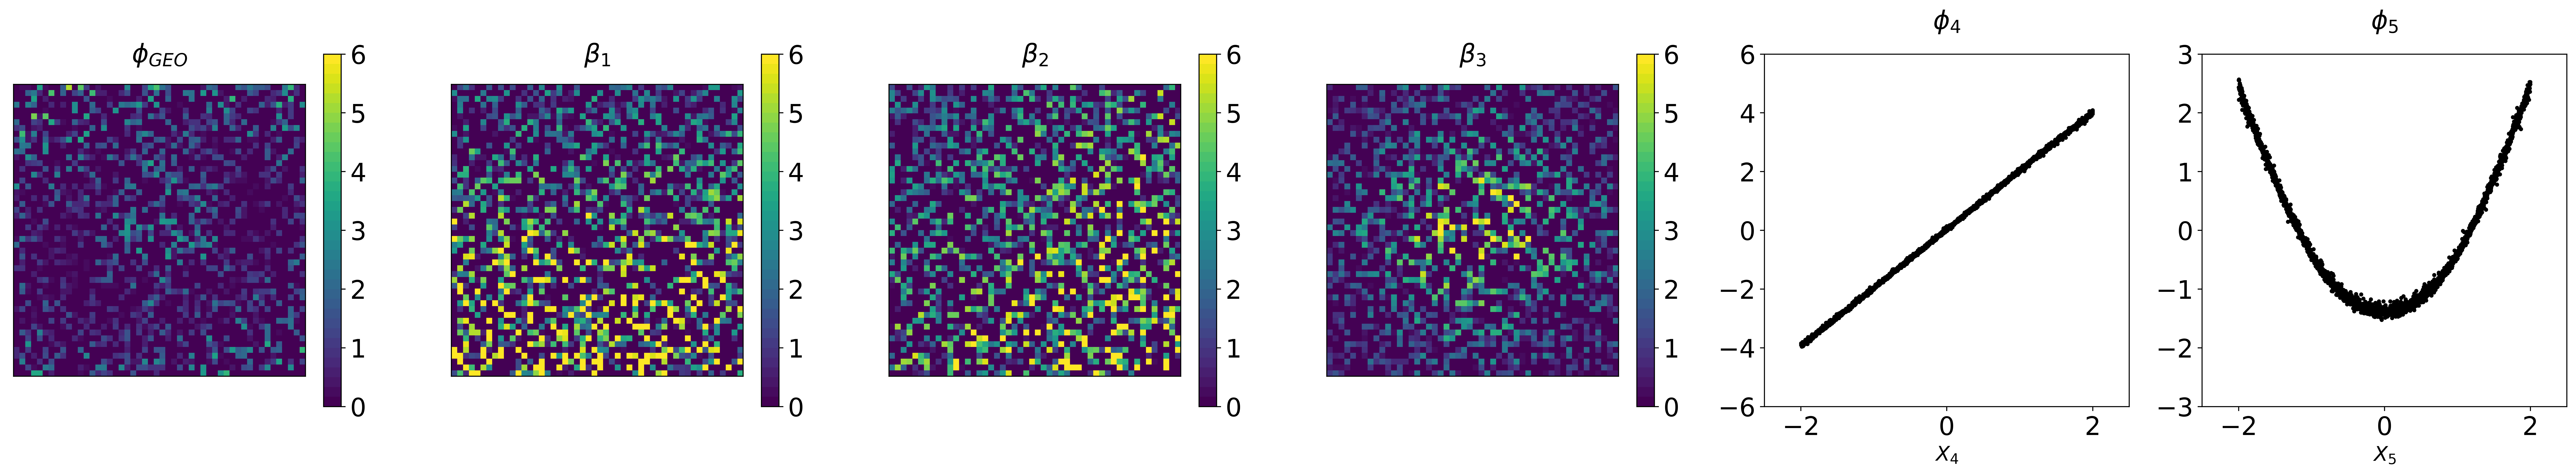

In [28]:
plot_contribution(pred_b, k=6, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[4, 5])

In [77]:
background = shap.sample(X_coords, 200)

In [78]:
explainer_shap = shap.KernelExplainer(true_model_with_uncertainty.predict, background)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [79]:
explanation = explainer_shap(X_coords)

100%|██████████| 2500/2500 [12:44<00:00,  3.27it/s]


In [80]:
explanation

.values =
array([[ 0.47858438,  1.70231673,  0.84861998, ...,  1.37281689,
        -0.96318126, -1.02355095],
       [ 1.50141326, -0.48464309, -0.69040168, ...,  1.50576644,
         0.73719365, -0.21363447],
       [ 2.46688933, -1.19605689, -0.8805741 , ..., -1.21895043,
         1.06628192, -0.725431  ],
       ...,
       [-7.2339781 , -4.06498447, -0.54146151, ..., -0.88965384,
        -0.58186244, -3.13883392],
       [-2.3101263 , -4.12869021,  0.70829973, ...,  1.45982097,
        -1.09744781, -2.22262868],
       [ 4.37814179, -2.81200638,  0.53316192, ...,  0.36711102,
        -0.85642951,  0.09304594]])

.base_values =
array([0.98918739, 0.98918739, 0.98918739, ..., 0.98918739, 0.98918739,
       0.98918739])

.data =
array([[ 0.1041137 ,  0.96491727,  1.01138065, ...,  1.62343764,
         0.        ,  0.        ],
       [ 0.74126874, -0.44003045, -0.93670497, ...,  1.6638808 ,
         1.        ,  0.        ],
       [ 1.34269675, -0.87573885, -1.14867671, ..., -0.20924

In [81]:
explanation = explanation.values

In [82]:
explanation.shape

(2500, 7)

In [83]:
X_coords.shape

(2500, 7)

In [84]:
explanation[:, 4].shape

(2500,)

In [85]:
sub_titles = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\phi_4$', r'$\phi_5$']

In [86]:
shap_true = [explanation[:, 0], explanation[:, 1], explanation[:, 2], [X_coords.values[:, 3], explanation[:, 3], -6, 6], [X_coords.values[:, 4], explanation[:, 4], -3, 3]]

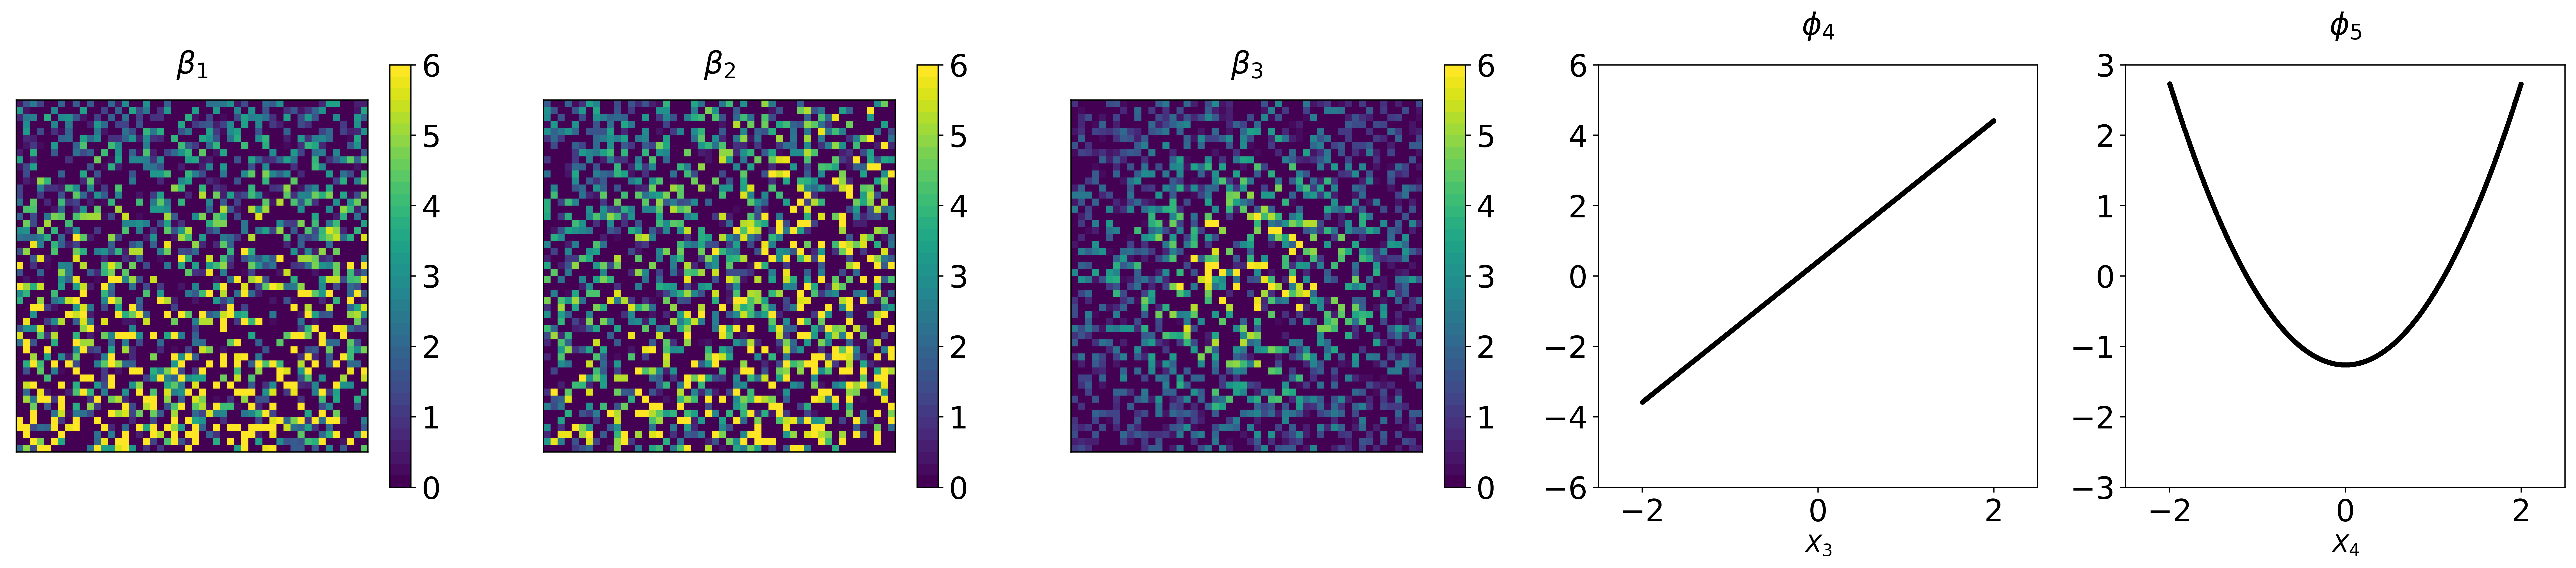

In [87]:
plot_contribution(shap_true, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - SHAP', non_spatial=[3, 4])

In [109]:
background = X_coords.sample(100).values

In [110]:
from geoshapley import GeoShapleyExplainer

In [111]:
explainer_geoshap = GeoShapleyExplainer(true_model_with_uncertainty.predict, background)

In [112]:
geoshap_result = explainer_geoshap.explain(X_coords)





  0%|          | 0/2500 [00:00<?, ?it/s]



  0%|          | 8/2500 [00:00<00:38, 64.00it/s]



  1%|          | 16/2500 [00:04<14:04,  2.94it/s]



  1%|          | 24/2500 [00:05<08:54,  4.63it/s]



  1%|▏         | 32/2500 [00:05<06:02,  6.81it/s]



  2%|▏         | 40/2500 [00:05<04:39,  8.80it/s]



  2%|▏         | 48/2500 [00:06<03:38, 11.21it/s]



  2%|▏         | 56/2500 [00:06<03:04, 13.27it/s]



  3%|▎         | 64/2500 [00:07<02:38, 15.37it/s]



  3%|▎         | 72/2500 [00:07<02:18, 17.49it/s]



  3%|▎         | 80/2500 [00:07<02:06, 19.12it/s]



  4%|▎         | 88/2500 [00:08<01:59, 20.20it/s]



  4%|▍         | 96/2500 [00:08<01:52, 21.31it/s]



  4%|▍         | 104/2500 [00:08<02:04, 19.22it/s]



  4%|▍         | 112/2500 [00:09<01:59, 20.02it/s]



  5%|▍         | 120/2500 [00:09<01:54, 20.85it/s]



  5%|▌         | 128/2500 [00:09<01:49, 21.59it/s]



  5%|▌         | 136/2500 [00:10<01:49, 21.60it/s]



  6%|▌         | 144/2500 [00:10<01:45, 22.24it

In [131]:
spatial_effects = geoshap_result.get_svc(col=[0, 1, 2], coef_type='raw', include_primary=True)

In [132]:
effects_geoshap = [spatial_effects[:, 0], spatial_effects[:, 1], spatial_effects[:, 2], [X_coords.values[:, 3], geoshap_result.primary[:,-2], -6, 6], [X_coords.values[:, 4], geoshap_result.primary[:,-1], -3, 3]]

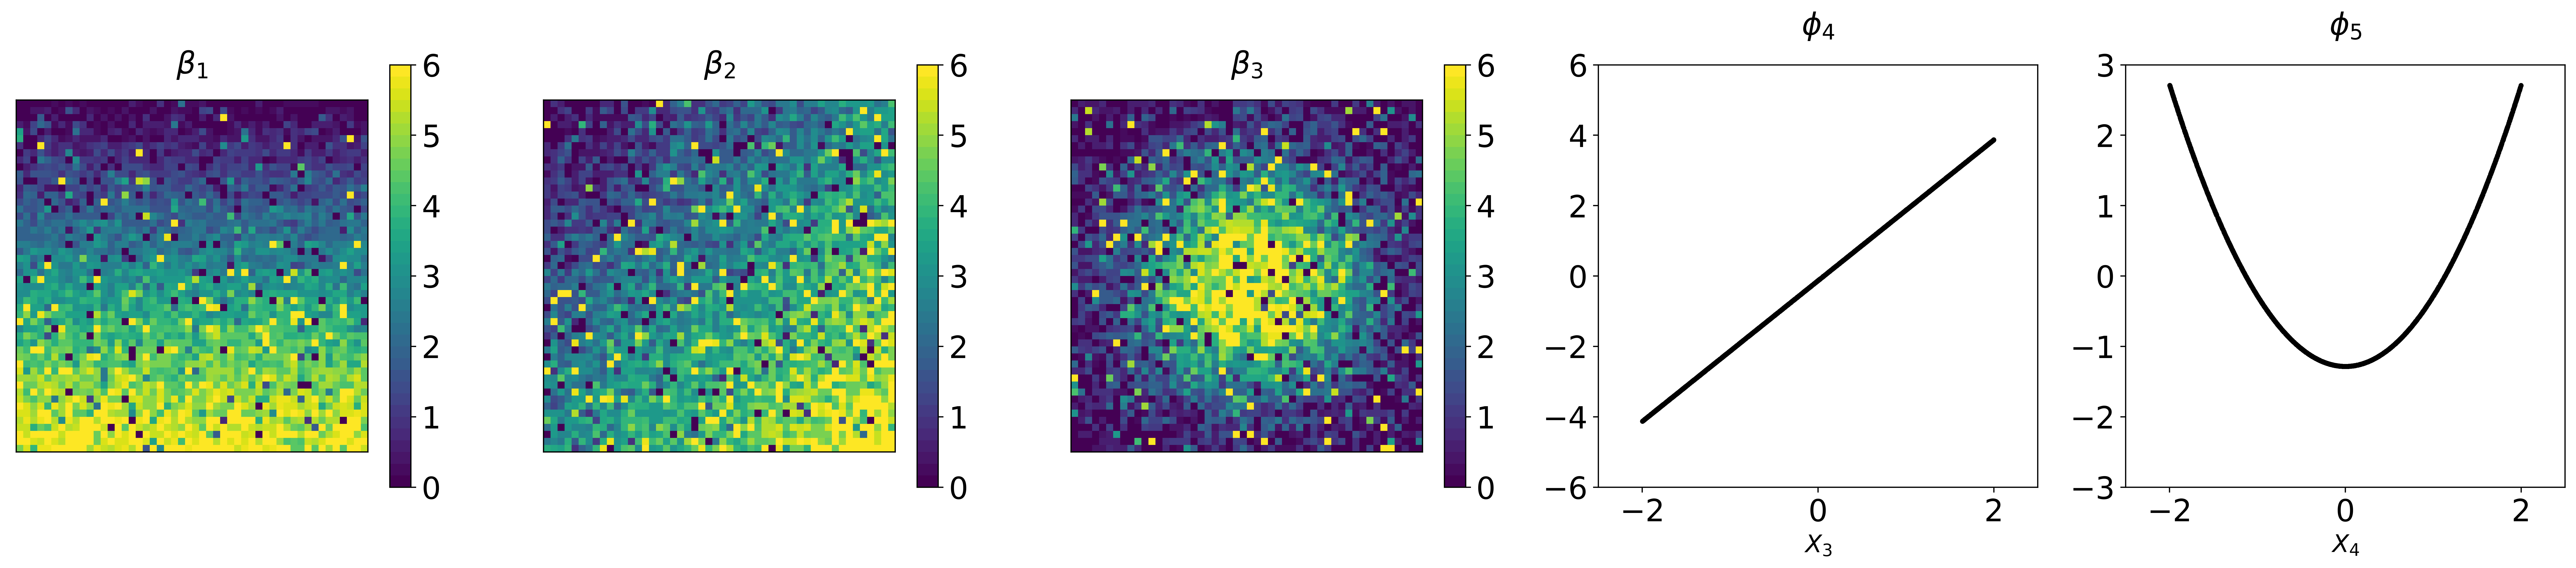

In [133]:
plot_contribution(effects_geoshap, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - GeoShapley', non_spatial=[3, 4])

In [ ]:
plot_contribution(pred_b, k=6, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[4, 5])

In [29]:
X1_cover = (pred_results['X1_shap'] <= pred_results['X1_upper_bound']) & (pred_results['X1_shap'] >= pred_results['X1_lower_bound'])

In [30]:
X2_cover = (pred_results['X2_shap'] <= pred_results['X2_upper_bound']) & (pred_results['X2_shap'] >= pred_results['X2_lower_bound'])

In [31]:
X3_cover = (pred_results['X3_shap'] <= pred_results['X3_upper_bound']) & (pred_results['X3_shap'] >= pred_results['X3_lower_bound'])

In [32]:
b_cover = [X1_cover.values, X2_cover.values, X3_cover.values]

In [33]:
sub_titles = [r'$Cover_1$', r'$Cover_2$', r'$Cover_3$']

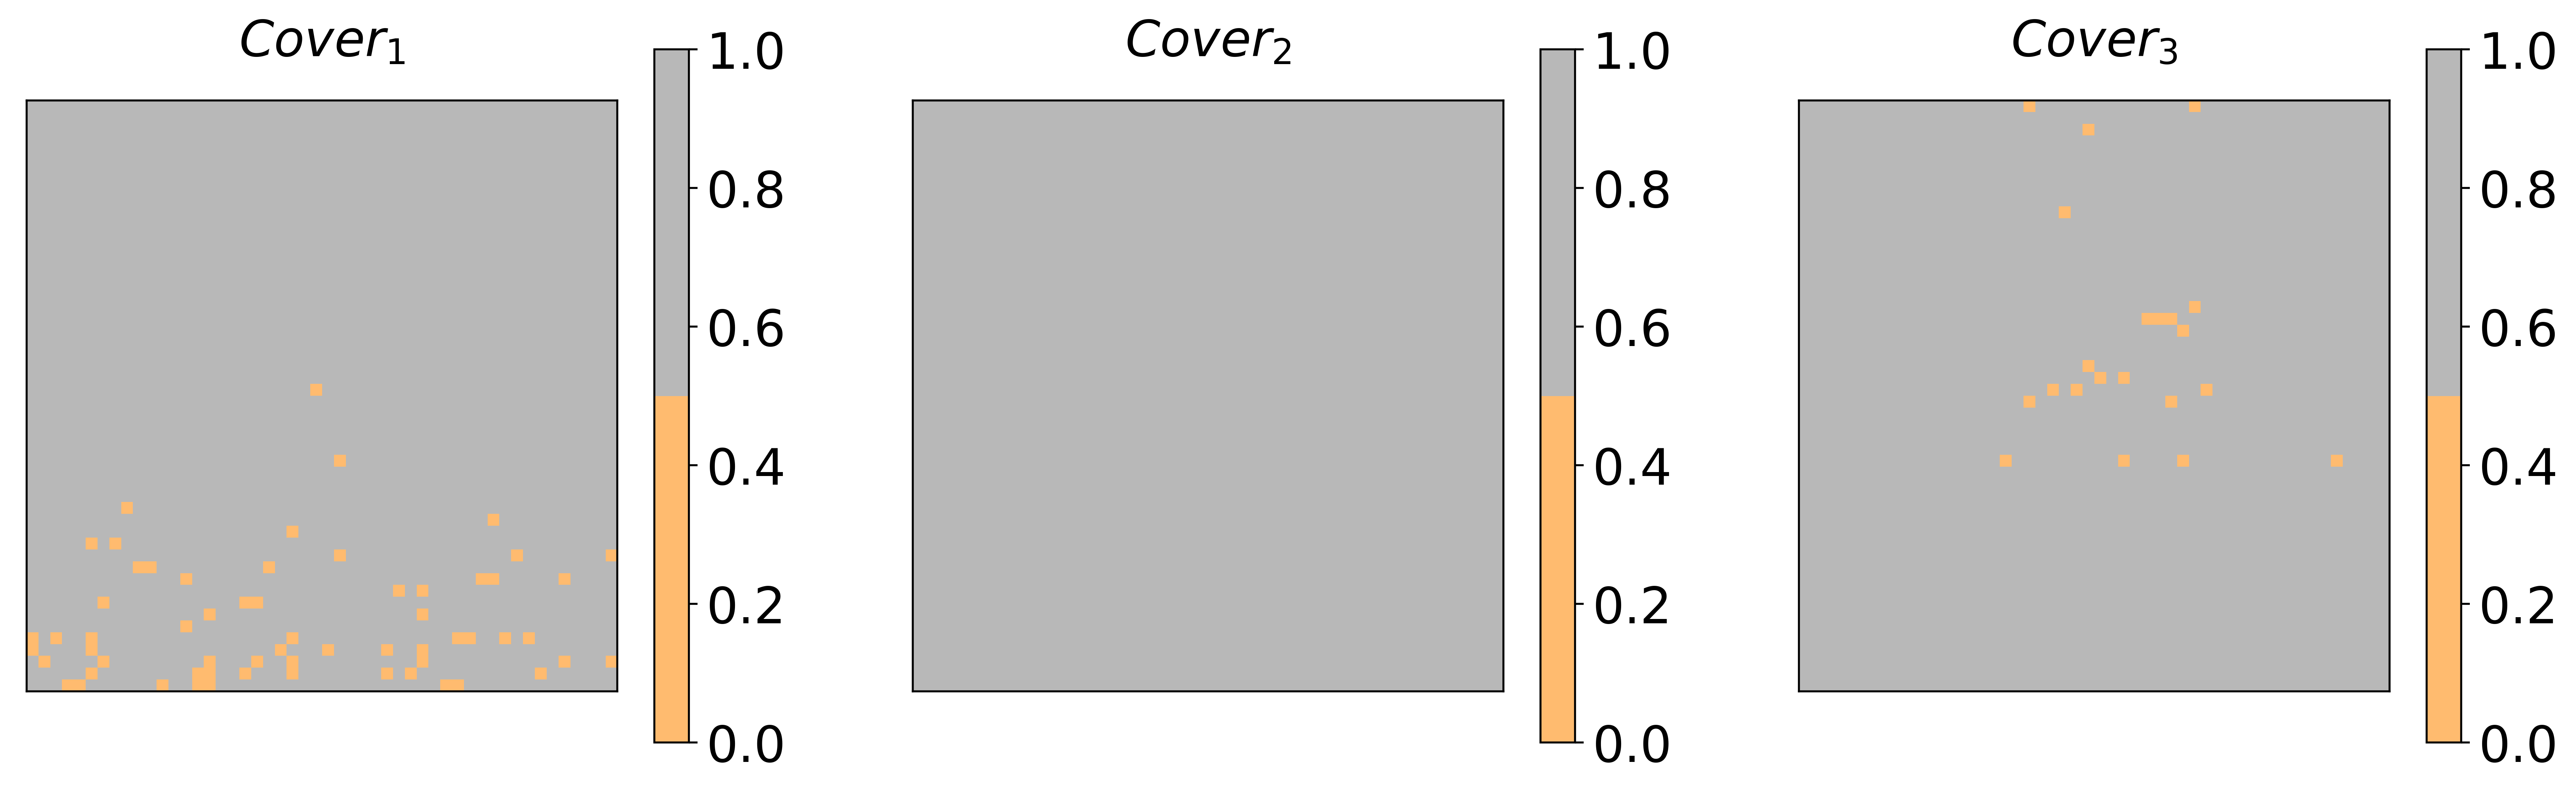

In [34]:
binary_cmap = ListedColormap(['#ffbb6f', '#b8b8b8'])
plot_contribution(b_cover, k=3, sub_titles=sub_titles, vmin=0, vmax=1, title='Coverage - ConformalSHAP', non_spatial=[], cmap=binary_cmap)

In [35]:
plt.rcParams['font.size'] = 16

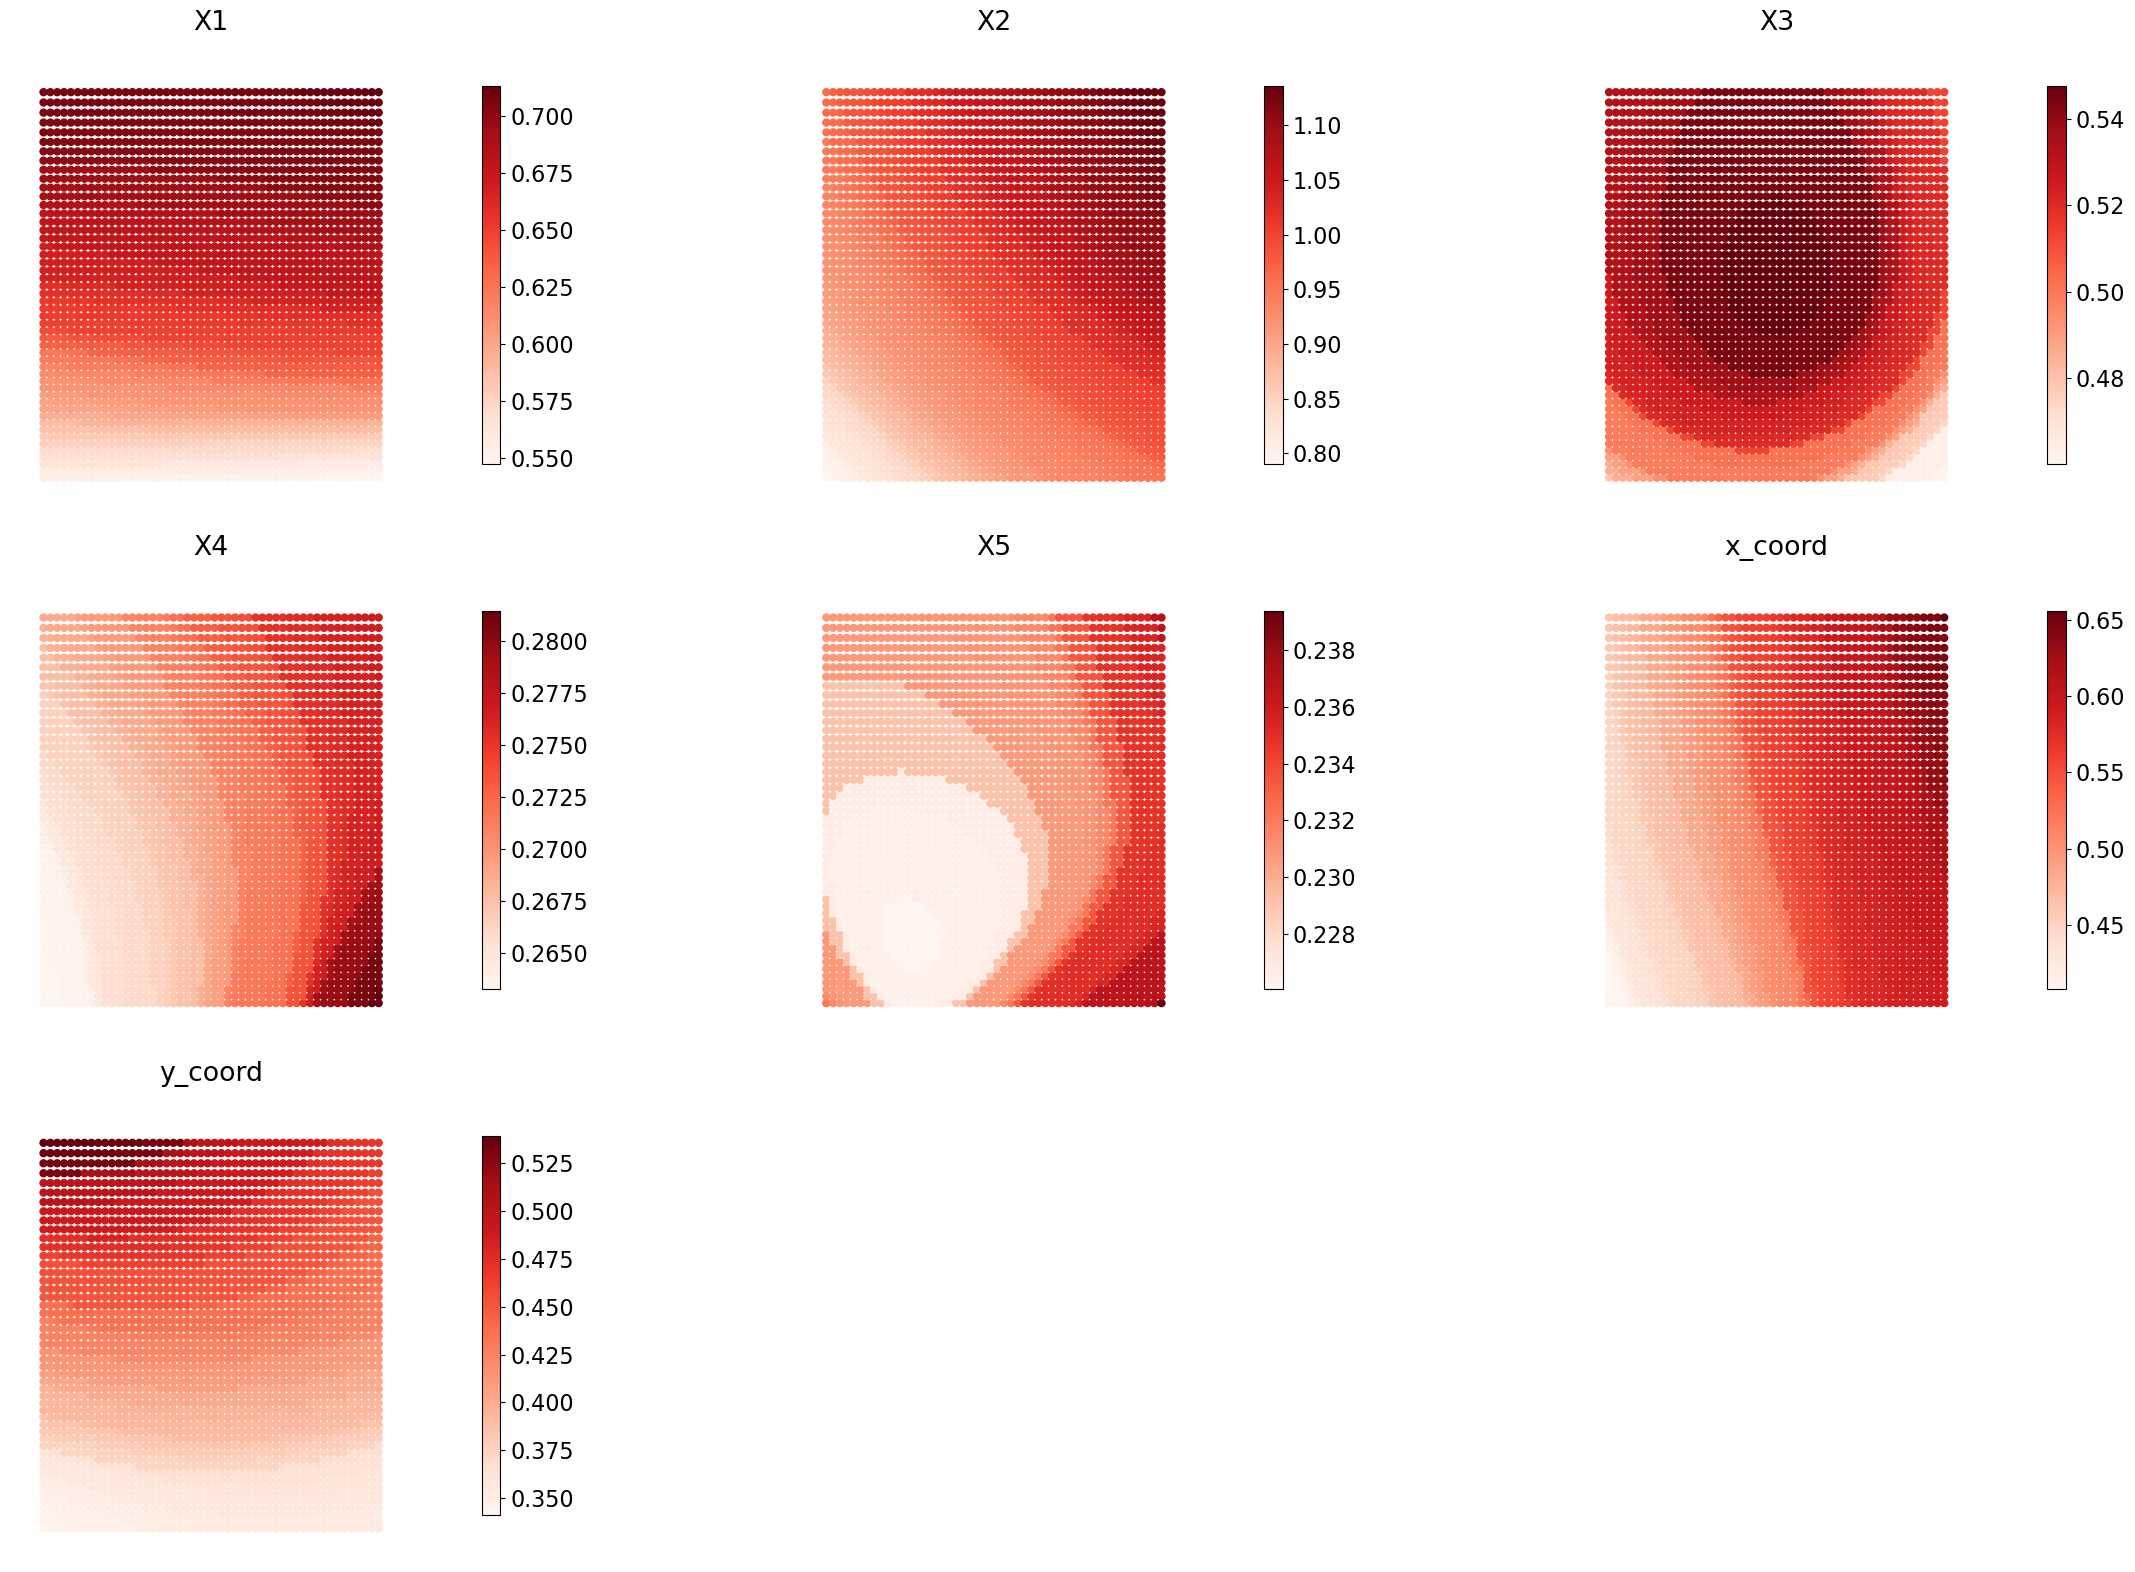

In [36]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [37]:
geo_uncertainty_sum = pred_results['X1_geo_uncertainty'] + pred_results['X2_geo_uncertainty'] + pred_results['X3_geo_uncertainty'] + pred_results['X4_geo_uncertainty'] + pred_results['X5_geo_uncertainty']

In [38]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

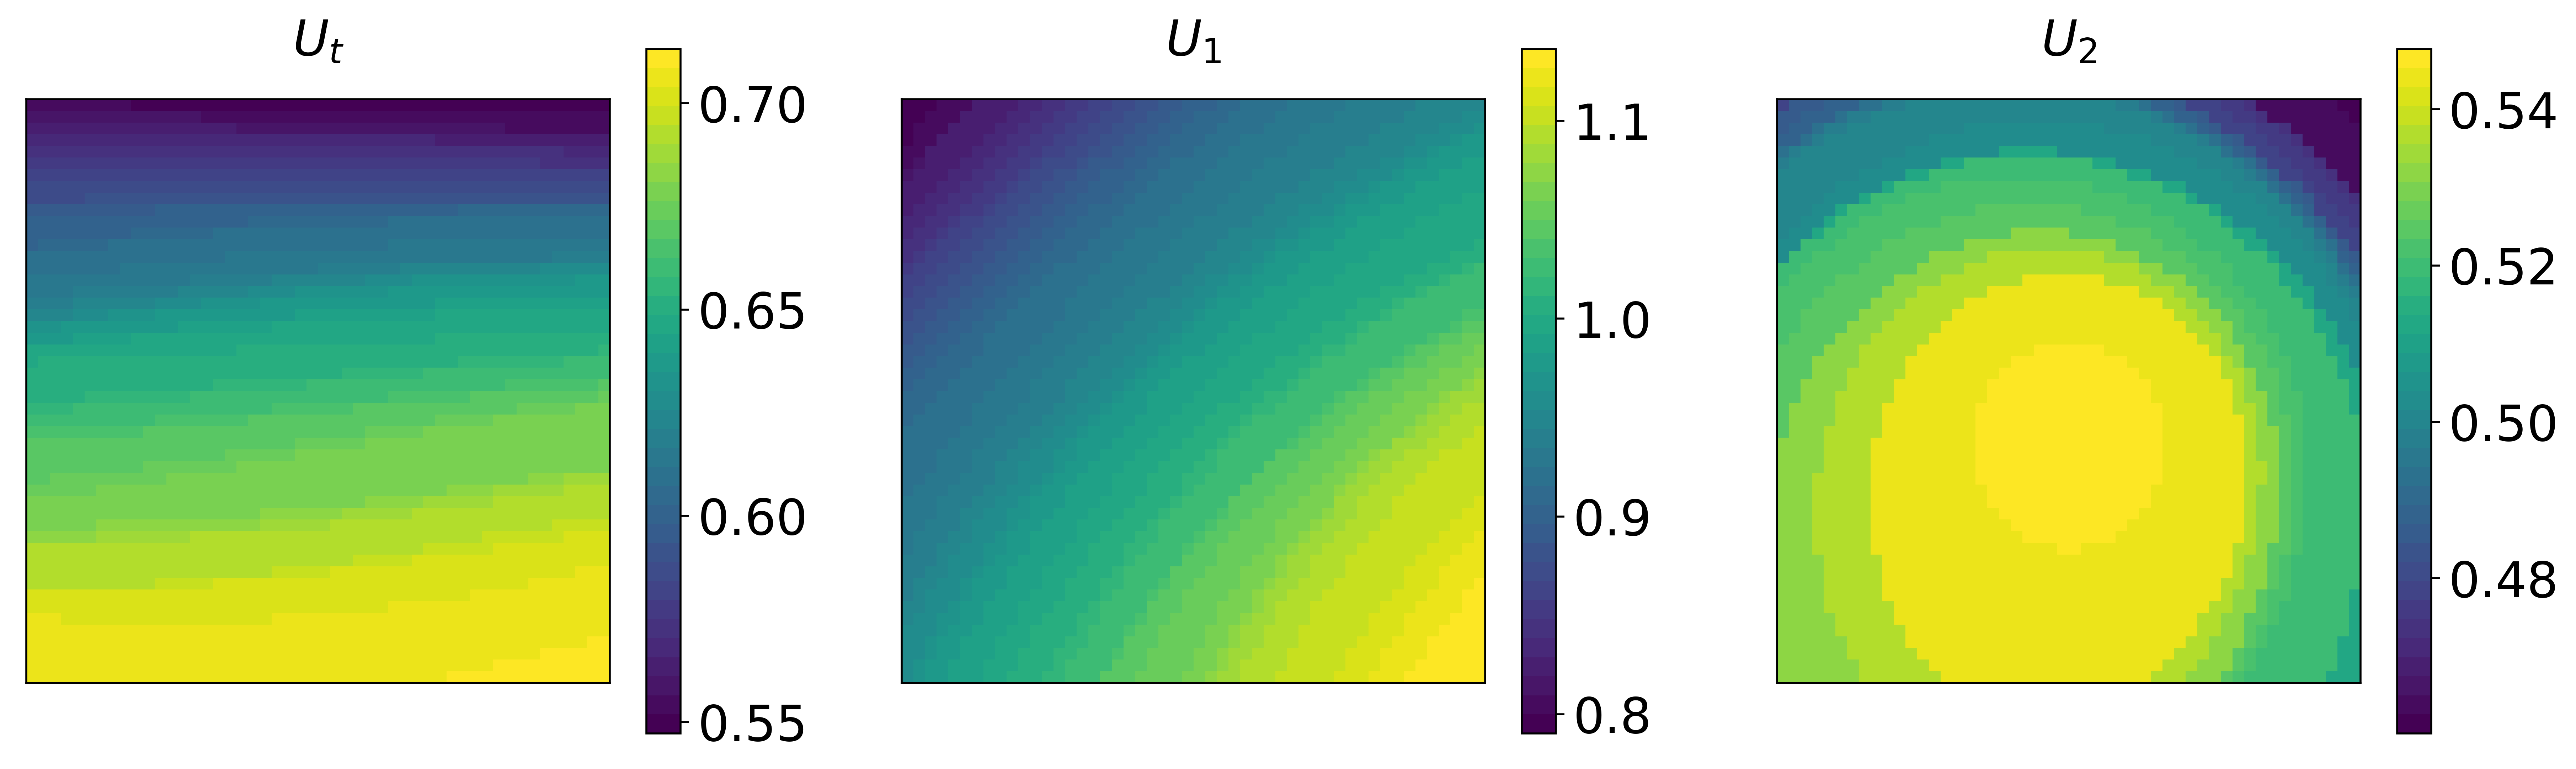

In [39]:
plot_contribution([pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=3, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

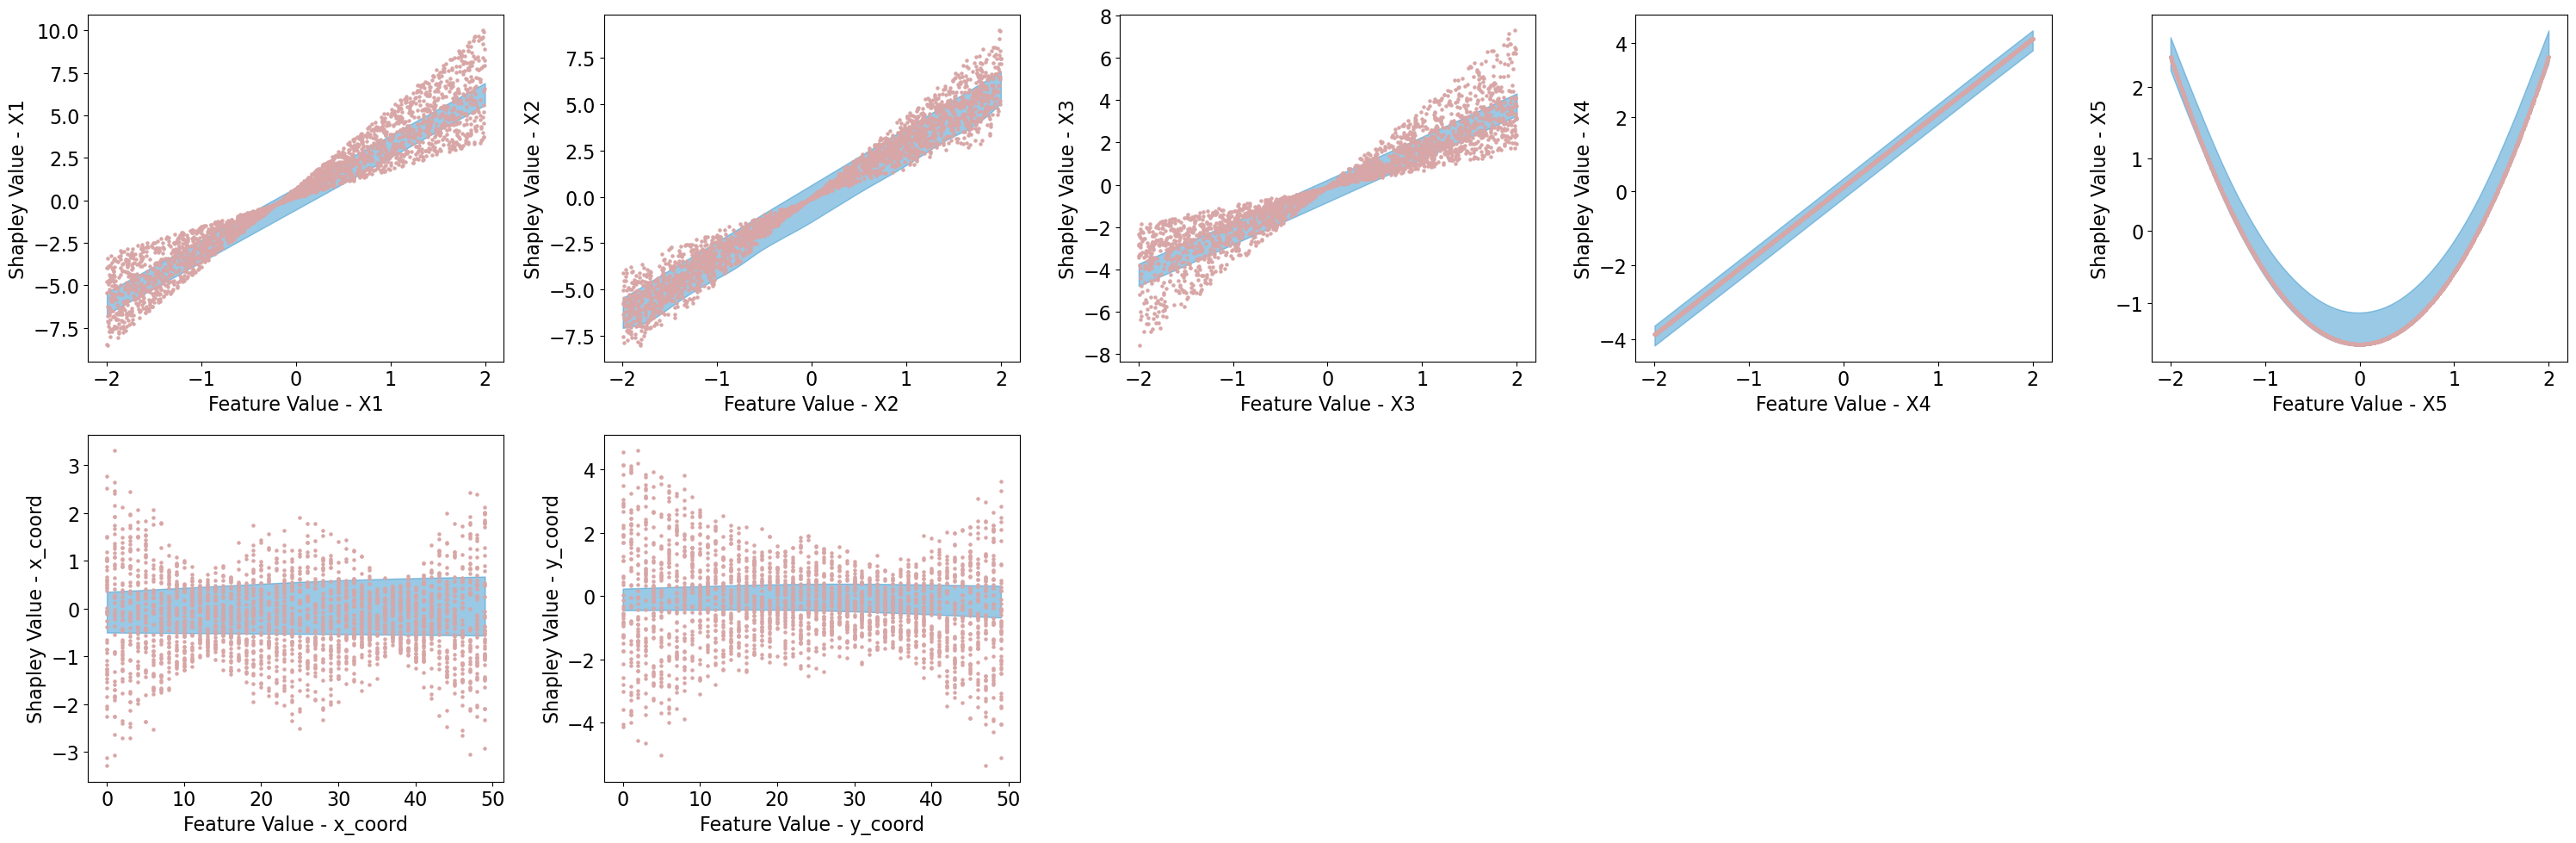

In [40]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)

In [41]:
explainer_without_uncertainty = GeoConformalizedExplainer(true_model_without_uncertainty, X_train, X_calib, loc_calib.values, loc.values, 0.1, 10)

In [42]:
results = explainer_without_uncertainty.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

Training SHAP


ExactExplainer explainer: 2001it [02:06, 14.45it/s]                          


Calibrating SHAP


ExactExplainer explainer: 501it [00:29, 11.56it/s]                         


Testing SHAP


ExactExplainer explainer: 2501it [02:26, 15.85it/s]                          


Explaining Variables


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [43]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     0.9624  0.985903  0.449793  14.351401      13.610568
X2                     0.9992  0.988538  0.396920  13.744562      13.457001
X3                     0.9644  0.972277  0.406454   5.959096       5.279495
X4                     0.9764  0.996650  0.135829   5.507205       5.427905
X5                     0.8864  0.938642  0.293964   1.408369       1.262291
x_coord                0.9372  0.687331  0.468936   0.703302       0.513662
y_coord                0.9236  0.904400  0.420490   1.849501       1.577228

In [44]:
pred_results = results.result

In [45]:
results.result_geo

X1_shap   X2_shap   X3_shap   X4_shap   X5_shap  x_coord_shap  \
0     0.402282  1.560145  0.784895  2.591669  1.150156     -1.182780   
1     1.471923 -0.742340 -0.820640  2.256475  1.283106      0.609109   
2     2.481585 -1.491541 -1.018764 -3.776410 -1.441611      0.962861   
3     1.260048  1.854833 -1.146176 -0.640815 -1.193696     -0.423604   
4    -2.881446  0.039190 -0.630565  2.332113 -1.469569      0.109652   
...        ...       ...       ...       ...       ...           ...   
2495 -7.560012 -3.413808 -0.025156 -2.519255  2.221087     -0.571663   
2496  1.974218 -2.923845  0.419647  0.905112 -1.475219     -0.670329   
2497 -7.193156 -4.640635 -0.665105  3.224179 -1.112315     -0.556437   
2498 -2.190753 -4.707821  0.636344  4.206248  1.237160     -1.088796   
2499  4.604215 -3.370276  0.454522  1.183082  0.144450     -0.855815   

      y_coord_shap  X1_value  X2_value  X3_value  ...  x_coord_pred  \
0        -1.176394  0.104114  0.964917  1.011381  ...     -1.041189   
1        -0.322766  0.741269 -0.440030 -0.936705  ...      1.062462   
2        -0.857672  1.342697 -0.875739 -1.148677  ...      1.253013   
3        -1.198843  0.615061  1.082512 -1.266801  ...     -0.136770   
4         3.581061 -1.851912  0.026923 -0.659943  ...      0.644841   
...            ...       ...       ...       ...  ...           ...   
2495     -3.391793 -1.798074 -0.779403  0.012337  ...     -0.443915   
2496     -0.841395  0.239688 -0.666447  0.497581  ...     -0.487646   
2497     -3.160428 -1.719665 -1.038000 -0.700350  ...     -0.422714   
2498     -2.354208 -0.650496 -1.045958  0.776005  ...     -0.879152   
2499     -0.151372  0.801800 -0.750421  0.581807  ...     -0.542183   

      y_coord_geo_uncertainty  y_coord_uncertainty  y_coord_upper_bound  \
0                    0.623429             0.752831            -1.131773   
1                    0.623429             0.752831            -0.012268   
2                    0.623429             0.752831            -0.395528   
3                    0.623429             0.752831            -0.752774   
4                    0.623429             0.752831             3.630794   
...                       ...                  ...                  ...   
2495                 0.893959             0.752831            -1.511413   
2496                 0.893959             0.752831             0.351123   
2497                 0.865967             0.752831            -1.587298   
2498                 0.865967             0.752831            -0.969940   
2499                 0.865967             0.752831             1.004687   

      y_coord_lower_bound  y_coord_coverage_probability  y_coord_pred     x  \
0               -2.378630                        0.9236     -1.755202   0.0   
1               -1.259126                        0.9236     -0.635697   1.0   
2               -1.642385                        0.9236     -1.018957   2.0   
3               -1.999631                        0.9236     -1.376203   3.0   
4                2.383936                        0.9236      3.007365   4.0   
...                   ...                           ...           ...   ...   
2495            -3.299331                        0.9236     -2.405372  45.0   
2496            -1.436796                        0.9236     -0.542837  46.0   
2497            -3.319231                        0.9236     -2.453264  47.0   
2498            -2.701874                        0.9236     -1.835907  48.0   
2499            -0.727247                        0.9236      0.138720  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (47.00000 49.00000)  
2498  49.0  POINT (48.00000 49.00000)  

In [46]:
b = pred_results[['X1_pred', 'X2_pred', 'X3_pred', 'X4_pred', 'X5_pred']]

In [47]:
pred_b = [b['X1_pred'].values, b['X2_pred'].values, b['X3_pred'].values, [X_coords.values[:, 3], b['X4_pred'].values, -6, 6], [X_coords.values[:, 4], b['X5_pred'].values, -2, 5]]

In [48]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_{4}(X_4)$', r'$f_5(X_5)$']

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000015605BA4670> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

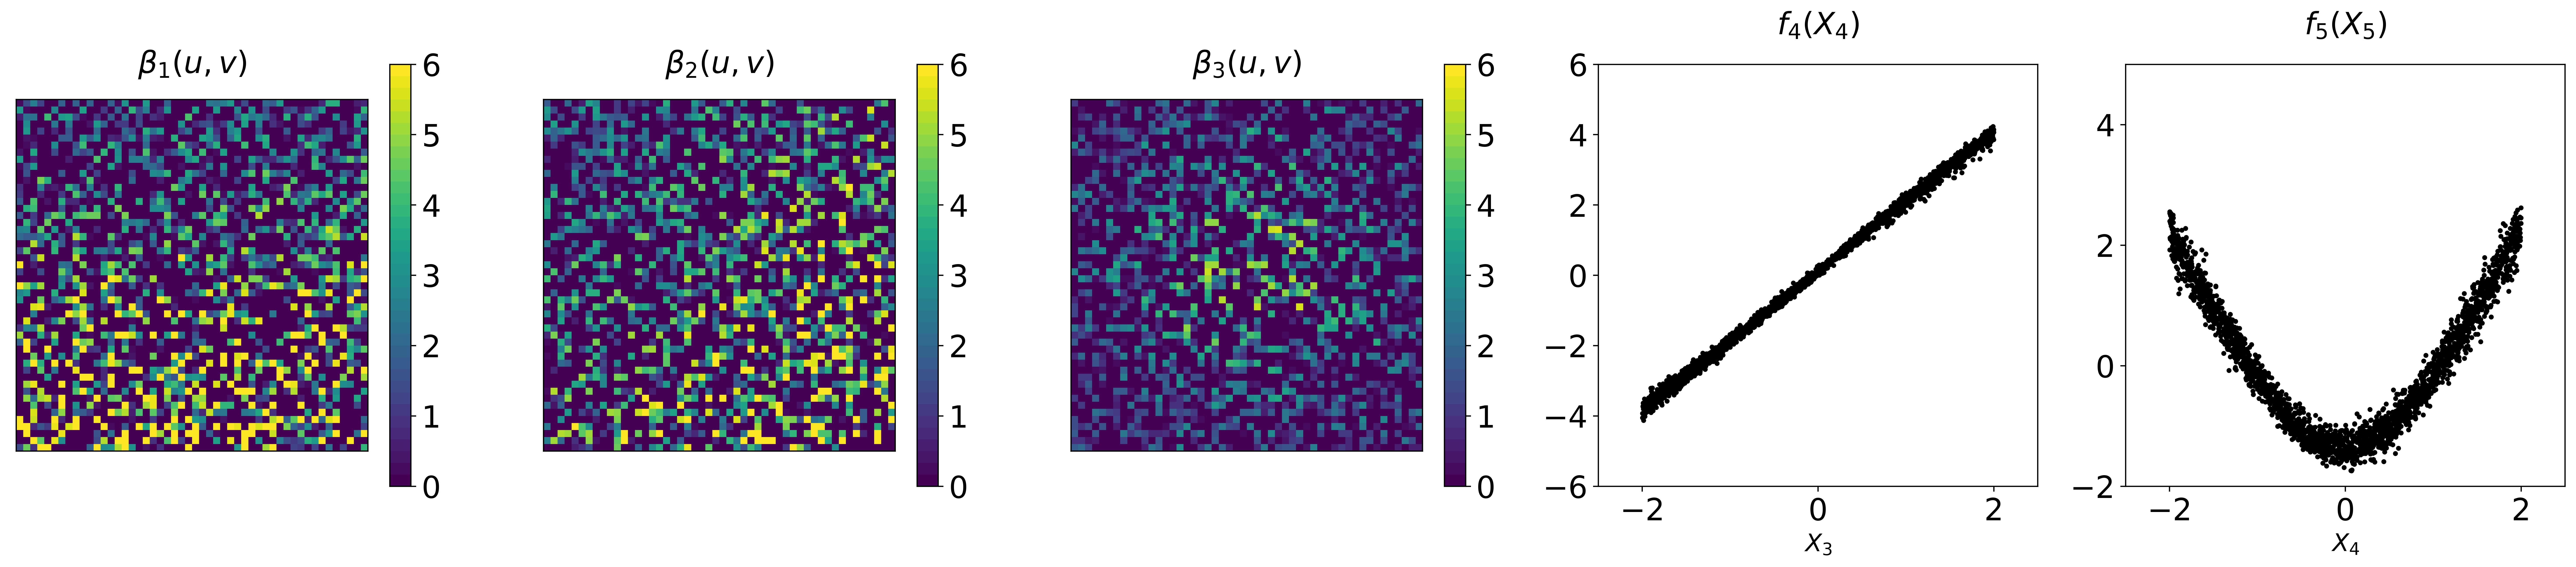

In [49]:
plot_contribution(pred_b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[3, 4])

In [50]:
plt.rcParams['font.size'] = 16

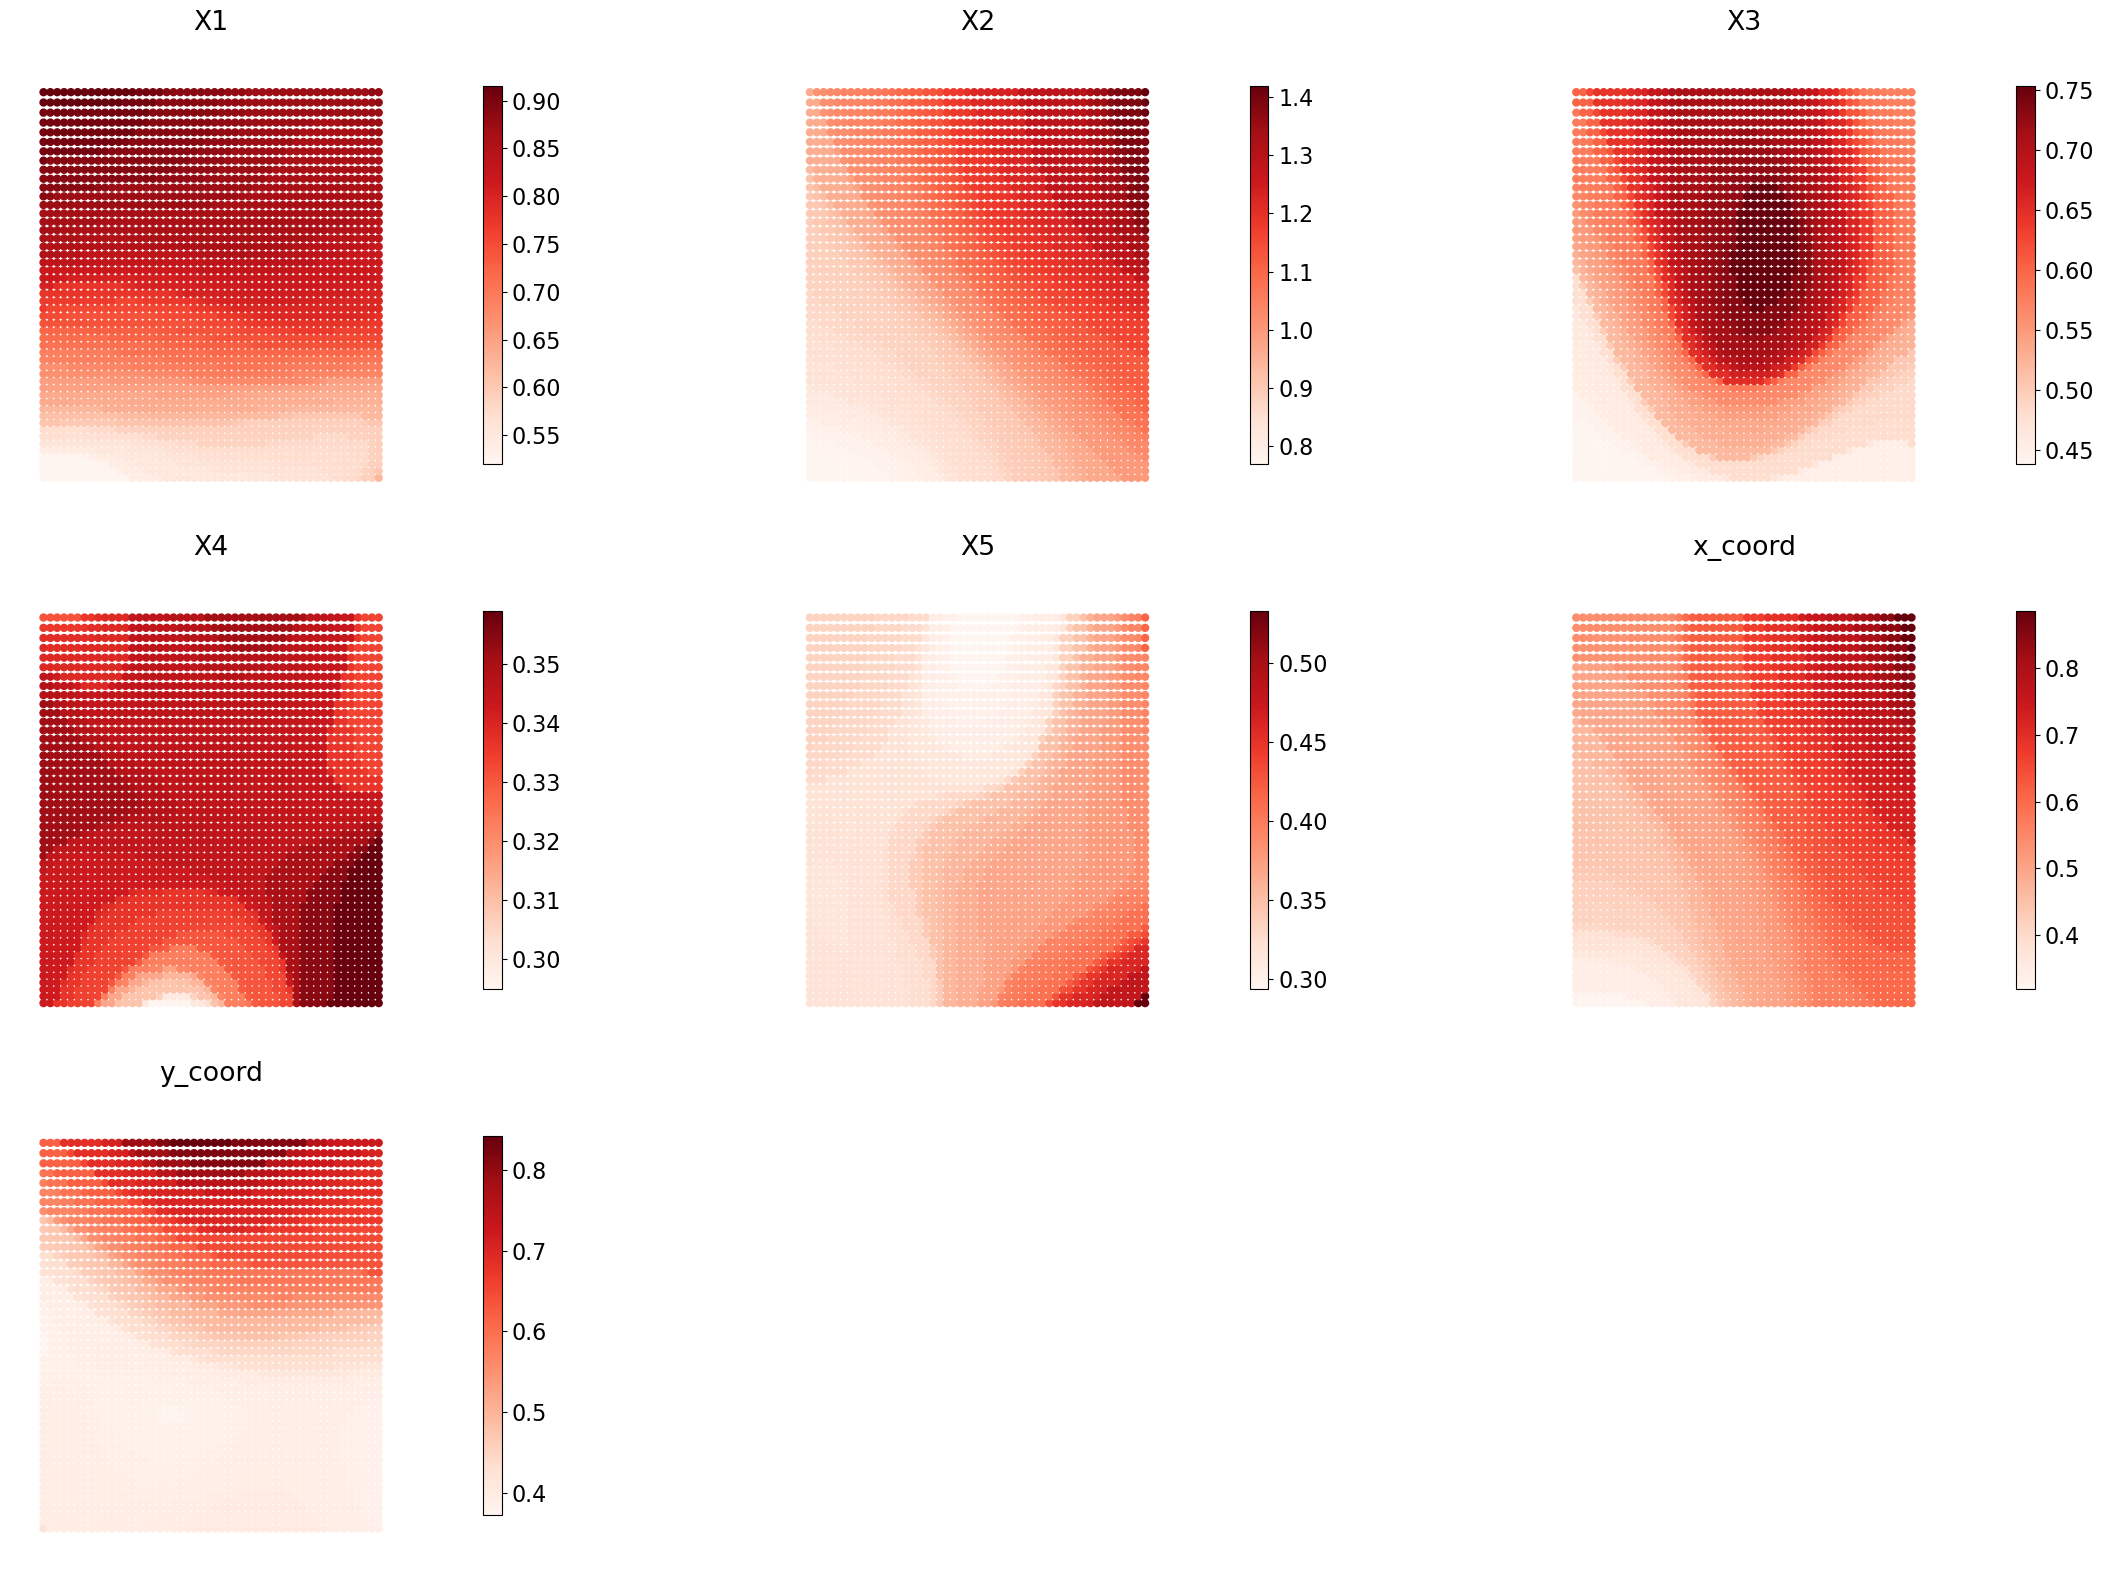

In [51]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [52]:
geo_uncertainty_sum = pred_results['X1_geo_uncertainty'] + pred_results['X2_geo_uncertainty'] + pred_results['X3_geo_uncertainty'] + pred_results['X4_geo_uncertainty'] + pred_results['X5_geo_uncertainty']

In [53]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

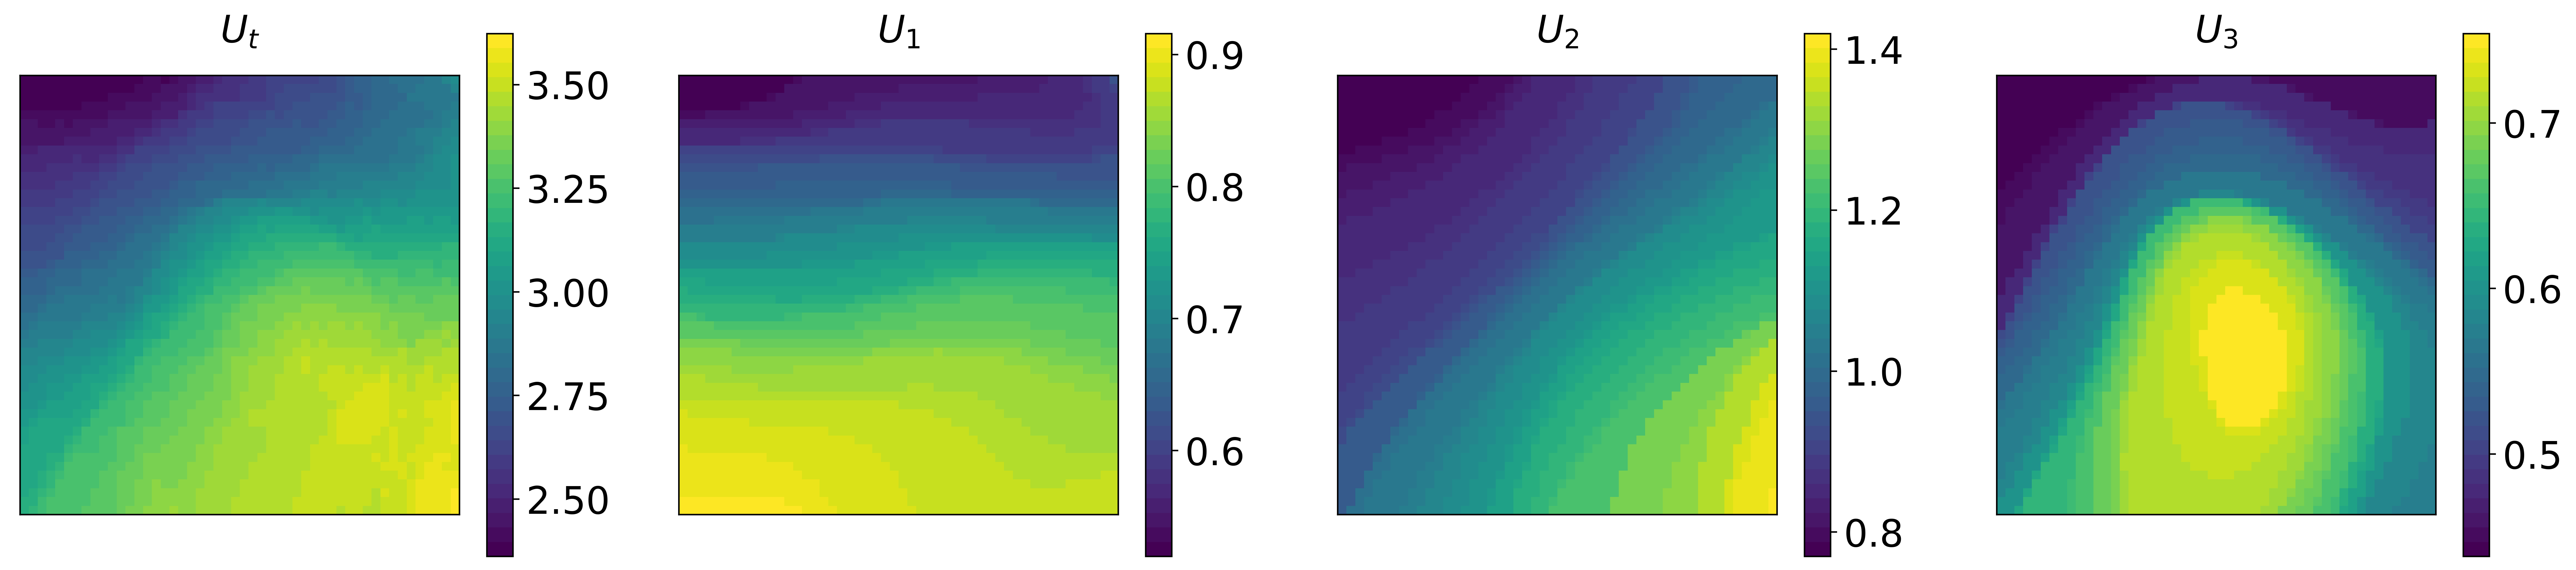

In [54]:
plot_contribution([geo_uncertainty_sum.values, pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=4, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

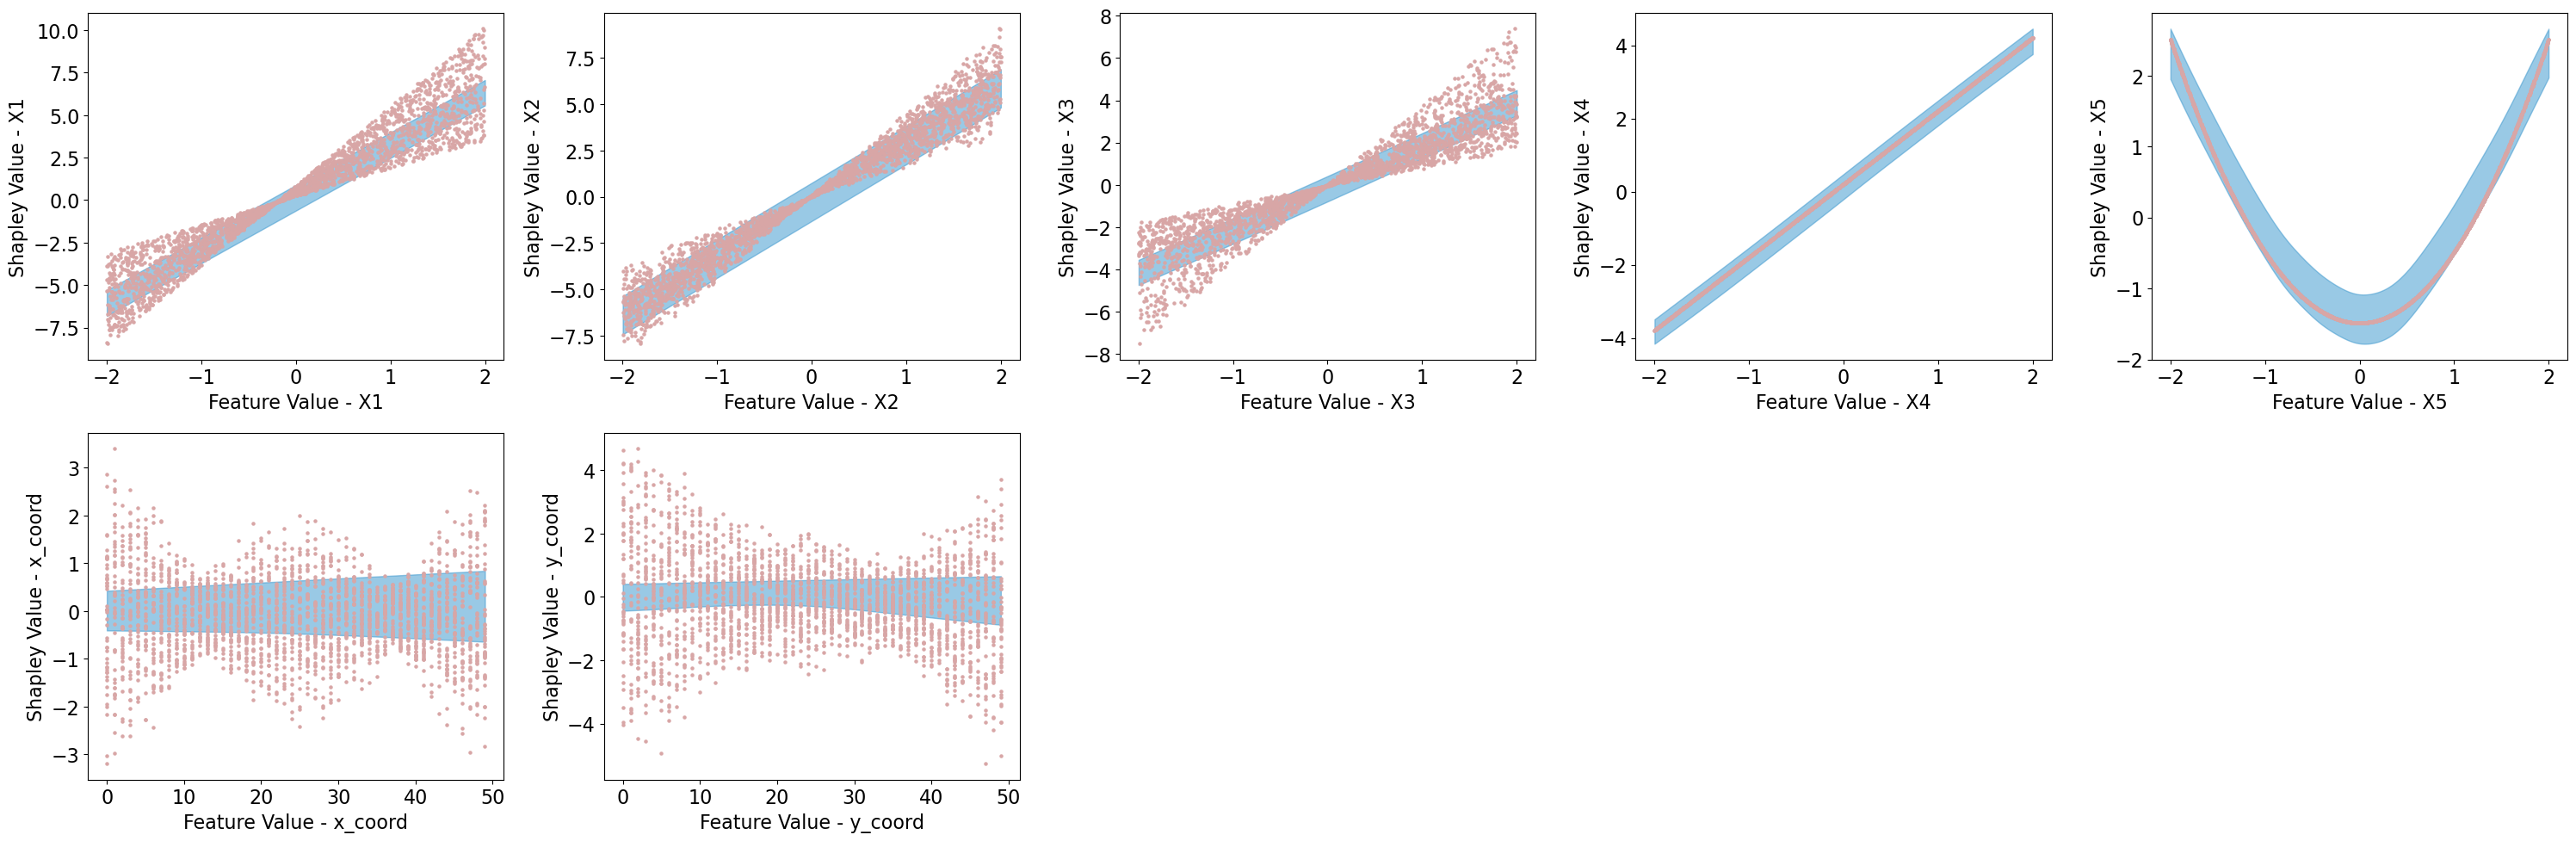

In [55]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)